In [1]:
%matplotlib_svg
import pylab as pl
import numpy as np
from scipy import linalg

## 线性代数-linalg

### 解线性方程组

In [39]:
import numpy as np
from scipy import linalg

m, n = 500, 50
A = np.random.rand(m, m)
B = np.random.rand(m, n)
X1 = linalg.solve(A, B)
X2 = np.dot(linalg.inv(A), B)
print np.allclose(X1, X2)
%timeit linalg.solve(A, B)
%timeit np.dot(linalg.inv(A), B)

True
100 loops, best of 3: 10.1 ms per loop
10 loops, best of 3: 20 ms per loop


In [3]:
luf = linalg.lu_factor(A)
X3 = linalg.lu_solve(luf, B)
np.allclose(X1, X3)

True

In [4]:
M, N = 1000, 100
np.random.seed(0)
A = np.random.rand(M, M)
B = np.random.rand(M, N)
Ai = linalg.inv(A)
luf = linalg.lu_factor(A)   
%timeit linalg.inv(A)
%timeit np.dot(Ai, B)
%timeit linalg.lu_factor(A)    
%timeit linalg.lu_solve(luf, B) 

10 loops, best of 3: 131 ms per loop
100 loops, best of 3: 9.65 ms per loop
10 loops, best of 3: 52.6 ms per loop
100 loops, best of 3: 13.8 ms per loop


### 最小二乘解

In [36]:
from numpy.lib.stride_tricks import as_strided

def make_data(m, n, noise_scale): #❶
    np.random.seed(42)
    x = np.random.standard_normal(m) 
    h = np.random.standard_normal(n) 
    y = np.convolve(x, h) 
    yn = y + np.random.standard_normal(len(y)) * noise_scale * np.max(y)
    return x, yn, h
    
def solve_h(x, y, n):      #❷
    X = as_strided(x, shape=(len(x)-n+1, n), strides=(x.itemsize, x.itemsize)) #❸
    Y = y[n-1:len(x)]      #❹
    h = linalg.lstsq(X, Y) #❺
    return h[0][::-1]      #❻

In [37]:
x, yn, h = make_data(1000, 100, 0.4)   
H1 = solve_h(x, yn, 120)
H2 = solve_h(x, yn, 80)

print "Average error of H1:", np.mean(np.abs(H[:100] - h))
print "Average error of H2:", np.mean(np.abs(h[:80] - H2))

Average error of H1: 0.301548854044
Average error of H2: 0.295842215834


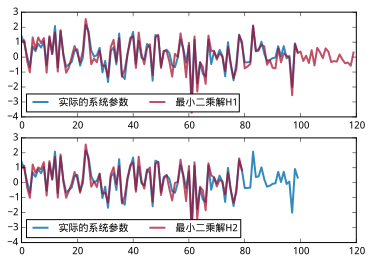

In [19]:
#%figonly=实际的系统参数与最小二乘解的比较
fig, (ax1, ax2) = pl.subplots(2, 1, figsize=(6, 4))
ax1.plot(h, linewidth=2, label=u"实际的系统参数")
ax1.plot(H, linewidth=2, label=u"最小二乘解H1", alpha=0.7)
ax1.legend(loc="best", ncol=2)
ax1.set_xlim(0, len(H))

ax2.plot(h, linewidth=2, label=u"实际的系统参数")
ax2.plot(H2, linewidth=2, label=u"最小二乘解H2", alpha=0.7)
ax2.legend(loc="best", ncol=2)
ax2.set_xlim(0, len(H));

### 特征值和特征向量

In [20]:
A = np.array([[1, -0.3], [-0.1, 0.9]])
evalues, evectors = linalg.eig(A)
%C evalues; evectors

             evalues                          evectors          
----------------------------------  ----------------------------
[ 1.13027756+0.j,  0.76972244+0.j]  [[ 0.91724574,  0.79325185],
                                     [-0.3983218 ,  0.60889368]]


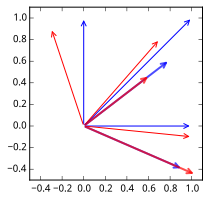

In [21]:
#%figonly=线性变换将蓝色箭头变换为红色箭头
points = np.array([[0, 1.0], [1.0, 0], [1, 1]])

def draw_arrows(points, **kw):
    props = dict(color="blue", arrowstyle="->")
    props.update(kw)
    for x, y in points:
        pl.annotate("",
                    xy=(x, y), xycoords='data',
                    xytext=(0, 0), textcoords='data',
                    arrowprops=props)

draw_arrows(points)
draw_arrows(np.dot(A, points.T).T, color="red")    
draw_arrows(evectors.T, alpha=0.7, linewidth=2)
draw_arrows(np.dot(A, evectors).T, color="red", alpha=0.7, linewidth=2)    

ax = pl.gca()
ax.set_aspect("equal")
ax.set_xlim(-0.5, 1.1)
ax.set_ylim(-0.5, 1.1);

In [22]:
np.random.seed(42)
t = np.random.uniform(0, 2*np.pi, 60)

alpha = 0.4
a = 0.5
b = 1.0
x = 1.0 + a*np.cos(t)*np.cos(alpha) - b*np.sin(t)*np.sin(alpha)
y = 1.0 + a*np.cos(t)*np.sin(alpha) - b*np.sin(t)*np.cos(alpha)
x += np.random.normal(0, 0.05, size=len(x))
y += np.random.normal(0, 0.05, size=len(y))

In [27]:
D = np.c_[x**2, x*y, y**2, x, y, np.ones_like(x)]
A = np.dot(D.T, D)
C = np.zeros((6, 6))
C[[0, 1, 2], [2, 1, 0]] = 2, -1, 2
evalues, evectors = linalg.eig(A, C)     #❶
evectors = np.real(evectors)
err = np.mean(np.dot(D, evectors)**2, 0) #❷
p = evectors[:, np.argmin(err) ]         #❸
print p

[-0.55214278  0.5580915  -0.23809922  0.54584559 -0.08350449 -0.14852803]


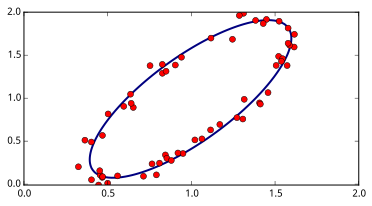

In [28]:
#%figonly=用广义特征向量计算的拟合椭圆
def ellipse(p, x, y):
    a, b, c, d, e, f = p
    return a*x**2 + b*x*y + c*y**2 + d*x + e*y + f

X, Y = np.mgrid[0:2:100j, 0:2:100j]
Z = ellipse(p, X, Y)
pl.plot(x, y, "ro", alpha=0.5)
pl.contour(X, Y, Z, levels=[0]);

### 奇异值分解-SVD

In [2]:
r, g, b = np.rollaxis(pl.imread("vinci_target.png"), 2).astype(float)
img = 0.2989 * r + 0.5870 * g + 0.1140 * b
img.shape

(505, 375)

In [3]:
U, s, Vh = linalg.svd(img)
%C 5 U.shape; s.shape; Vh.shape

 U.shape       s.shape      Vh.shape 
----------     -------     ----------
(505, 505)     (375,)      (375, 375)


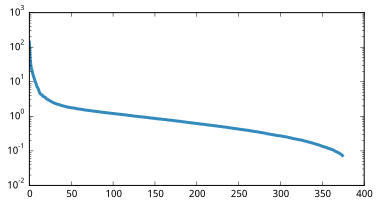

In [4]:
#%fig=按从大到小排列的奇异值
pl.semilogy(s, lw=3);

In [5]:
def composite(U, s, Vh, n):
    return np.dot(U[:, :n], s[:n, np.newaxis] * Vh[:n, :])

print np.allclose(img, composite(U, s, Vh, len(s)))

True


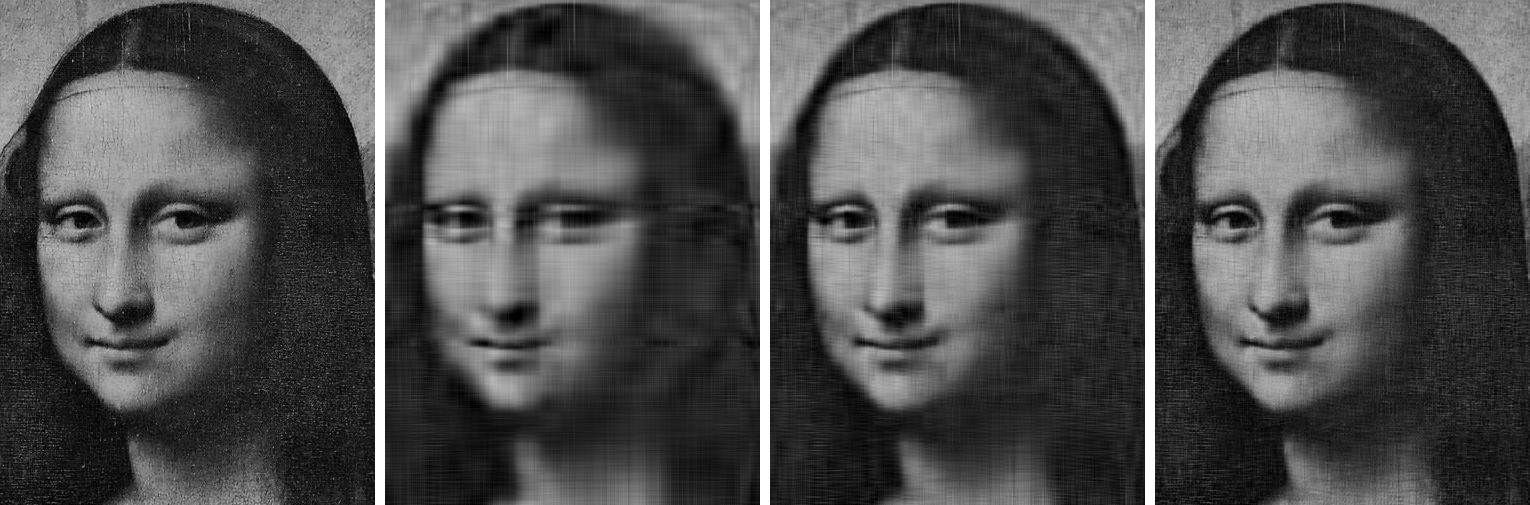

In [6]:
#%fig=原始图像、使用10、20、50个向量合成的图像（从左到右）
img10 = composite(U, s, Vh, 10)
img20 = composite(U, s, Vh, 20)
img50 = composite(U, s, Vh, 50)

%array_image img; img10; img20; img50